In [ ]:
# GPU Status when Using Colab environment

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Sat Apr 30 04:52:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    44W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# RAM Status when Using Colab environment

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Import Necessary Packages

import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from glob import iglob
import wave
from scipy import signal
from IPython import display
from matplotlib import pyplot as plt
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import librosa
import gc

import tensorflow as tf
from keras.backend import dropout
from keras.layers.convolutional import Conv1D
from tensorflow import keras
from keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping



In [ ]:
# Mount with Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_data" here to where data is uploaded
customized_path_to_data = 'Colab Notebooks/urbansounds_8k_audio/'
data_path = prefix + customized_path_to_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Constants to be used
TOTAL_EXAMPLES = 8732
Fs = 22050            # Sampling frequency in Hz
EXAMPLE_DURATION = 5  # Duration of an example in seconds
SAMPLE_LENGTH = Fs * EXAMPLE_DURATION
NUM_CLASSES = 10
LONGEST_SAMPLE_LENGTH = 116247

MFCCs = 40 # ADJUST AS NECESSARY

FOLD1_EXAMPLES = 873
FOLD2_EXAMPLES = 888
FOLD3_EXAMPLES = 925
FOLD4_EXAMPLES = 990
FOLD5_EXAMPLES = 936
FOLD6_EXAMPLES = 823
FOLD7_EXAMPLES = 838
FOLD8_EXAMPLES = 806
FOLD9_EXAMPLES = 816
FOLD10_EXAMPLES = 837

MAX_PAD = 700

IMAGE_HEIGHT = 129
IMAGE_WIDTH = MAX_PAD


In [ ]:
# Helper function to create a list of lists for organization
def create_fold_data():
    fold1_audio = np.zeros(shape=(FOLD1_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold1_class = np.zeros(shape=(FOLD1_EXAMPLES, NUM_CLASSES))

    fold2_audio = np.zeros(shape=(FOLD2_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold2_class = np.zeros(shape=(FOLD2_EXAMPLES, NUM_CLASSES))

    fold3_audio = np.zeros(shape=(FOLD3_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold3_class = np.zeros(shape=(FOLD3_EXAMPLES, NUM_CLASSES))

    fold4_audio = np.zeros(shape=(FOLD4_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold4_class = np.zeros(shape=(FOLD4_EXAMPLES, NUM_CLASSES))

    fold5_audio = np.zeros(shape=(FOLD5_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold5_class = np.zeros(shape=(FOLD5_EXAMPLES, NUM_CLASSES))

    fold6_audio = np.zeros(shape=(FOLD6_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold6_class = np.zeros(shape=(FOLD6_EXAMPLES, NUM_CLASSES))

    fold7_audio = np.zeros(shape=(FOLD7_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold7_class = np.zeros(shape=(FOLD7_EXAMPLES, NUM_CLASSES))

    fold8_audio = np.zeros(shape=(FOLD8_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold8_class = np.zeros(shape=(FOLD8_EXAMPLES, NUM_CLASSES))

    fold9_audio = np.zeros(shape=(FOLD9_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold9_class = np.zeros(shape=(FOLD9_EXAMPLES, NUM_CLASSES))

    fold10_audio = np.zeros(shape=(FOLD10_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH))
    fold10_class = np.zeros(shape=(FOLD10_EXAMPLES, NUM_CLASSES))

    fold_data = [[fold1_audio, fold1_class], [fold2_audio, fold2_class], [fold3_audio, fold3_class],
                 [fold4_audio, fold4_class], [fold5_audio, fold5_class], [fold6_audio, fold6_class],
                 [fold7_audio, fold7_class], [fold8_audio, fold8_class], [fold9_audio, fold9_class],
                 [fold10_audio, fold10_class]]

    return fold_data

# Generate MFCC coefficients for every song
def generate_mfcc_data():
  fold_data = create_fold_data()

  longest_file = 0
  tracker = 1
  for i in range(1, 11):
    j = 0
    for filename in iglob(data_path + 'fold' + str(i) + '/*.wav'):
      print('Processing example', tracker ,'of 8732...')
      # We don't want any song data in here
      wavfilename = filename[69:]

      audio_normalised, sr = librosa.load(filename)

      mfccs = librosa.feature.mfcc(audio_normalised, sr=sr, n_mfcc=MFCCs)
      mfcc_mean = mfccs.mean(axis=1).T

      fold_data[i - 1][0][j] = mfcc_mean

      # Find class and convert to one hot encoding and append to class_data
      i1 = wavfilename.find('-')
      i2 = wavfilename[i1 + 1:].find('-')

      emotion_class = to_categorical(int(wavfilename[i1 + 1:i1 + 1 + i2]), NUM_CLASSES)
      fold_data[i - 1][1][j] = emotion_class
      j = j + 1
      tracker = tracker + 1

  return fold_data

# Generate spectrogram data for every 
def gen_spectro_image():
    fold_data = create_fold_data()
    tracker = 1
    for i in range(1, NUM_FOLDS + 1):
        j = 0
        for filename in iglob(data_path + 'fold' + str(i) + '/*.wav'):
            print('Processing example', tracker, 'of 8732...')
            # We don't want any song data in here
            wavfilename = filename[55:]
            print(wavfilename)

            audio, sr = librosa.load(filename)

            spec_out = plt.specgram(audio, Fs=sr, cmap='plasma')
            plt.show()
            spectrogram = spec_out[0]
            spectrogram = normalize_data(spectrogram)
            print(wavfilename)
            print(MAX_PAD - spectrogram.shape[1])
            spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, MAX_PAD - spectrogram.shape[1])))
            fold_data[i - 1][0][j] = spectrogram

            # Find class and convert to one hot encoding and append to class_data
            i1 = wavfilename.find('-')
            i2 = wavfilename[i1 + 1:].find('-')

            emotion_class = to_categorical(int(wavfilename[i1 + 1:i1 + 1 + i2]), NUM_CLASSES)
            fold_data[i - 1][1][j] = emotion_class
            j = j + 1
            tracker = tracker + 1

    return fold_data

# Generate spectrogram data
def gen_spectro_image():
    fold_data = create_fold_data()
    tracker = 1
    for i in range(1, NUM_FOLDS + 1):
        j = 0
        for filename in iglob(data_path + 'fold' + str(i) + '/*.wav'):
            print('Processing example', tracker, 'of 8732...')
            # We don't want any song data in here
            wavfilename = filename[55:]
            print(wavfilename)

            audio, sr = librosa.load(filename)

            spec_out = plt.specgram(audio, Fs=sr, cmap='plasma')
            plt.show()
            spectrogram = spec_out[0]
            spectrogram = normalize_data(spectrogram)
            print(wavfilename)
            print(MAX_PAD - spectrogram.shape[1])
            spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, MAX_PAD - spectrogram.shape[1])))
            fold_data[i - 1][0][j] = spectrogram

            # Find class and convert to one hot encoding and append to class_data
            i1 = wavfilename.find('-')
            i2 = wavfilename[i1 + 1:].find('-')

            emotion_class = to_categorical(int(wavfilename[i1 + 1:i1 + 1 + i2]), NUM_CLASSES)
            fold_data[i - 1][1][j] = emotion_class
            j = j + 1
            tracker = tracker + 1

    return fold_data

# Load data from file if saved on a local machine
def generate_data_from_file():
  path = data_path + 'saved_data/40_mfccs/'
  g_mean = 'g_mean/'
  a_mean = 'a_mean/'

  path = path + a_mean

  fold_data = []
  for i in range(10):
    # Print message to console
    print('Processing Fold', i + 1, 'of 10')

    # Create pair of fold data and class_data
    data_pair = []

    # First element in pair is data
    data_pair.append(np.load(path + 'fold' + str(i + 1) + '.npy'))
    data_pair.append(np.load(path + 'fold' + str(i + 1) + '_class.npy'))
    
    fold_data.append(data_pair)

  return fold_data


In [ ]:

def save_as_npy(fold_data):
  path = data_path + 'saved_data/40_mfccs/'
  g_mean = 'g_mean/'
  a_mean = 'a_mean/'

  path = path + a_mean

  # Save all numpy arrays as .npy files
  for i in range(len(fold_data)):
    pair = fold_data[i]

    # Save mfcc mean data
    np.save(path + 'fold' + str(i + 1), pair[0])

    # Save class data for corresponding fold
    np.save(path + 'fold' + str(i + 1) + '_class', pair[1])


In [ ]:
#save_as_npy(fold_data)

In [ ]:
# Define training, validation, and testing split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Takes parameter from 1 to 10, specifying what fold will be used for testing
def gen_train_test_split(fold_data, test_set=1, val_split=.2):
  assert test_set >= 1 and test_set <= 10

  x_test = fold_data[test_set - 1][0]
  y_test = fold_data[test_set - 1][1]

  num_train_examples = TOTAL_EXAMPLES - np.shape(x_test)[0]

  audio_data = np.zeros(shape=(num_train_examples, MFCCs))
  class_data = np.zeros(shape=(num_train_examples, NUM_CLASSES))

  j1 = 0
  for i in range(1, 11):    # Iterate over all folds
    if i != test_set:       # If we aren't looking at the test fold
      for example in range(len(fold_data[i - 1][0])):
        audio_data[j1] = fold_data[i - 1][0][example]
        class_data[j1] = fold_data[i - 1][1][example]
        j1 = j1 + 1

  # Split data into training and validation set
  x_train, x_val, y_train, y_val = train_test_split(audio_data, class_data,
                                                    test_size=val_split)

  return x_train, x_test, x_val, y_train, y_test, y_val 


def normalize_data(data):
  scaler = MinMaxScaler()
  scaler.fit(data)
  return scaler.transform(data)

def gen_spectro_data_from_file(path):
    #path = 'C:/Users/HP/Documents/CS_4824/UrbanSound8K/saved_data/spectro/'
    fold_data = []
    for i in range(10):
        # Print message to console
        print('Processing Fold', i + 1, 'of 10')

        # Create pair of fold data and class_data
        data_pair = []

        # First element in pair is data
        data_pair.append(np.load(path + 'spectro_fold' + str(i + 1) + '.npy'))
        data_pair.append(np.load(path + 'fold' + str(i + 1) + '_class.npy'))

        fold_data.append(data_pair)

    return fold_data

# Takes parameter from 1 to 10, specifying what fold will be used for testing
# Also reshapes data
def gen_train_test_split_image(fold_data, test_set=1, val_split=.2):
    assert 1 <= test_set <= 10

    x_test = fold_data[test_set - 1][0]
    y_test = fold_data[test_set - 1][1]

    num_train_examples = TOTAL_EXAMPLES - np.shape(x_test)[0]

    audio_data = np.zeros(shape=(num_train_examples, IMAGE_HEIGHT, IMAGE_WIDTH))
    class_data = np.zeros(shape=(num_train_examples, NUM_CLASSES))

    j1 = 0
    for i in range(1, 11):  # Iterate over all folds
        if i != test_set:  # If we aren't looking at the test fold
            for example in range(len(fold_data[i - 1][0])):
                audio_data[j1] = fold_data[i - 1][0][example]
                class_data[j1] = fold_data[i - 1][1][example]
                j1 = j1 + 1

    # Split data into training and validation set
    x_train, x_val, y_train, y_val = train_test_split(audio_data, class_data,
                                                      test_size=val_split)

    NUM_CHANNELS = 1
    x_train = x_train.reshape(x_train.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)
    x_test = x_test.reshape(x_test.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)
    x_val = x_val.reshape(x_val.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)

    return x_train, x_test, x_val, y_train, y_test, y_val


In [ ]:
data_path = prefix + 'Colab Notebooks/urbansounds_8k_audio/saved_data/spectro/'
fold_data = gen_spectro_data_from_file(path=data_path)
print(fold_data[0][0][0])

Processing Fold 1 of 10
Processing Fold 2 of 10
Processing Fold 3 of 10
Processing Fold 4 of 10
Processing Fold 5 of 10
Processing Fold 6 of 10
Processing Fold 7 of 10
Processing Fold 8 of 10
Processing Fold 9 of 10
Processing Fold 10 of 10
[[1.49945008e-07 9.44366194e-09 1.25481700e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.19010353e-07 1.36090988e-07 2.57080674e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.00631858e-07 9.60930216e-08 1.28161983e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.14491163e-14 4.13719334e-14 1.63491871e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.45303242e-15 1.78031357e-14 1.31576318e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.85868626e-15 1.16517844e-16 3.16027653e-16 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
model = None
gc.collect()

310

In [ ]:
# Build and compile CNN
def base_cnn(dropout=0.5, optimizer='Adam', filter_dim=3):
    """
  Define a convolutional neural network using the Sequential model. This is the
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
    model = Sequential()
    '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
    f_height = filter_dim
    f_width = filter_dim * 5

    p_height = filter_dim - 1
    p_width = filter_dim * 5 - 1

    model.add(Conv2D(32, (f_height, f_width), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (f_height, f_width), padding='same'))
    model.add(Activation('relu'))
    '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
    model.add(MaxPooling2D(pool_size=(p_height, p_width)))
    '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
    model.add(Dropout(dropout))
    '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
    model.add(Conv2D(64, (f_height, f_width), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (f_height, f_width), padding='same'))
    model.add(Activation('relu'))
    '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
    model.add(MaxPooling2D(pool_size=(p_height, p_width)))
    model.add(Dropout(dropout))
    '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
    opt = optimizer
    '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary())

    return model

In [ ]:
# Build and compile a simple DNN
def simple_dnn(dropout=0.5, optimizer='Adam'):
  model = Sequential([
    layers.Dense(int(MFCCs * 2), activation='relu', input_dim=MFCCs),
    layers.Dropout(dropout),
    layers.Dense(int(MFCCs * 1.2), activation='relu', input_dim=MFCCs),
    layers.Dropout(dropout),
    layers.Dense(NUM_CLASSES, activation='softmax')

  ])

  opt = optimizer
  model.compile(loss='categorical_crossentropy', optimizer=opt, 
                metrics=['accuracy'])
  print(model.summary())
  return model


# Define batch size and number of epochs to run for
batch_size = 64
epochs = 64

# Define early stopping callback
num_epochs_early_stop = 8
monitor = 'val_accuracy'
early_stop = EarlyStopping(monitor=monitor, verbose=1,
                           patience=num_epochs_early_stop)



In [ ]:
# Build and train the model
history = []
test_acc = []
for i in range(10):
    # Split data into training, validation, and testing set
    x_train, x_val, x_test, y_train, y_val, y_test = gen_train_test_split_image(fold_data, test_set=i + 1, val_split=.2)
    # model = simple_dnn(dropout=0.5, optimizer='Adam', hidden_layers=0)

    #model = None
    #with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    #  model = base_cnn(dropout=.25, optimizer='Adam', filter_dim=5)

    model = base_cnn(dropout=.25, optimizer='Adam', filter_dim=5)
    print('\nUsing Fold', i + 1, 'as Test Set\n')
    history.append(model.fit(x_train, y_train, epochs=epochs,
                             validation_data=(x_val, y_val),
                             shuffle=True, batch_size=batch_size, callbacks=early_stop))

    print('Evaluation on Test Set')
    test_acc.append(model.evaluate(x_test, y_test, verbose=1))

    # Delete data variables for memory clearing
    del x_train, x_val, x_test, y_train, y_val, y_test
    model = None
    gc.collect()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 129, 700, 32)      4032      
                                                                 
 activation (Activation)     (None, 129, 700, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 129, 700, 32)      128032    
                                                                 
 activation_1 (Activation)   (None, 129, 700, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 29, 32)        0         
                                                        

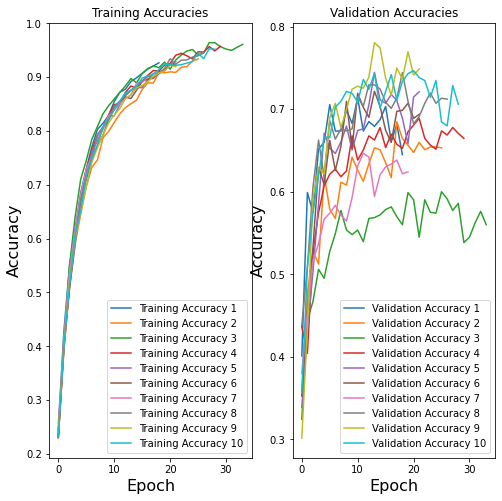

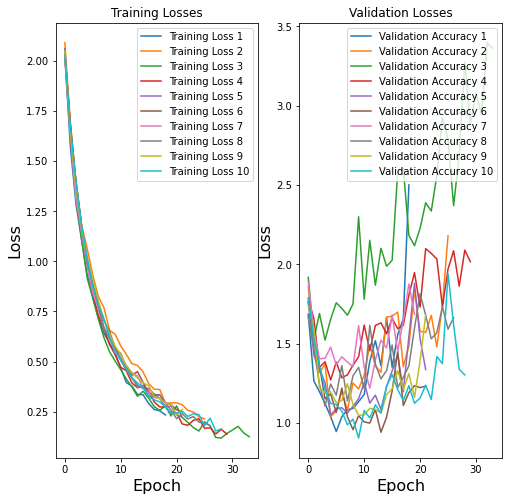

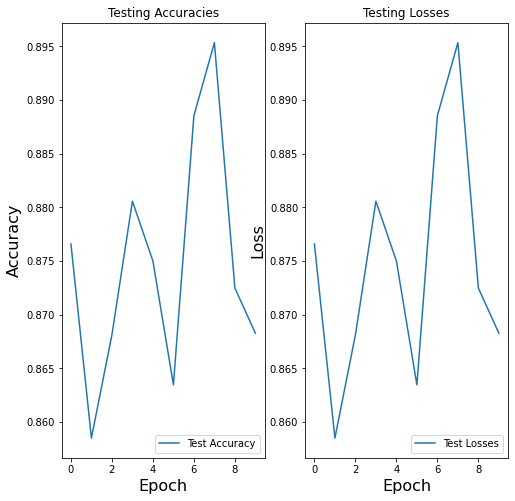

AttributeError: ignored

In [ ]:
import stat

# PLOT ACCURACIES
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
# Print training accuracies only on one subplot
for i in range(10):
    acc = history[i].history['accuracy']
    plt.plot(acc, label='Training Accuracy ' + str(i + 1))

plt.legend(loc='lower right')
plt.title('Training Accuracies')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.subplot(1, 2, 2)
# Print validation accuracies only on one subplot
for i in range(10):
    val_acc = history[i].history['val_accuracy']
    plt.plot(val_acc, label='Validation Accuracy ' + str(i + 1))

plt.legend(loc='lower right')
plt.title('Validation Accuracies')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

# PLOT LOSSES
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
# Print training losses only on one subplot
for i in range(10):
    loss = history[i].history['loss']
    plt.plot(loss, label='Training Loss ' + str(i + 1))

plt.legend(loc='upper right')
plt.title('Training Losses')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.subplot(1, 2, 2)
# Print validation losses only on one subplot
for i in range(10):
    val_loss = history[i].history['val_loss']
    plt.plot(val_loss, label='Validation Accuracy ' + str(i + 1))

plt.legend(loc='upper right')
plt.title('Validation Losses')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Plot evaluation/test across folds and print average loss and accuracies
test_accuracies = []
test_losses = []
for i in range(10):
    test_accuracies.append(test_acc[i][1])
    test_losses.append(test_acc[i][0])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Testing Accuracies')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Losses')
plt.legend(loc='lower right')
plt.title('Testing Losses')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

print('Average Test Accuracy: ' + str(stat.fmean(test_accuracies)))
print('Average Test Loss: ' + str(stat.fmean(test_losses)))